## Fitting models in BoTorch with a torch.optim.Optimizer

BoTorch provides a convenient `botorch.fit.fit_gpytorch_mll` function with sensible defaults that work on most basic models, including those that botorch ships with. Internally, this function uses L-BFGS-B to fit the parameters. However, in more advanced use cases you may need or want to implement your own model fitting logic.

This tutorial allows you to customize model fitting to your needs using the familiar PyTorch-style model fitting loop.

This tutorial is adapted from GPyTorch's [Simple GP Regression Tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) and has very few changes because the out-of-the box models that BoTorch provides are GPyTorch models; in fact, they are proper subclasses that add the `botorch.models.Model` API functions.

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import math

import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

### Set up function to model
In this tutorial we will model a simple sinusoidal function with i.i.d. Gaussian noise:

$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0, 0.15)$$

#### Initialize training data

In [3]:
# use regular spaced points on the interval [0, 1]
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device)
# training data needs to be explicitly multi-dimensional
train_X = train_X.unsqueeze(1)

# sample observed values and add some synthetic noise
train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)

#### Initialize the model
We will model the function using a `SingleTaskGP`, which by default uses a `GaussianLikelihood` and infers the unknown noise level.

The default optimizer for the `SingleTaskGP` is L-BFGS-B, which takes as input explicit bounds on the noise parameter. However, the `torch` optimizers don't support parameter bounds as input. To use the `torch` optimizers, then, we'll need to manually register a constraint on the noise level. When registering a constraint, the `softplus` transform is applied by default, enabling us to enforce a lower bound on the noise.

**Note**: Without manual registration, the model itself does not apply any constraints, due to the interaction between constraints and transforms. Although the `SingleTaskGP` constructor does in fact define a constraint, the constructor sets `transform=None`, which means that the constraint is not enforced. See the [GPyTorch constraints module](https://github.com/cornellius-gp/gpytorch/blob/master/gpytorch/constraints/constraints.py) for additional information.


In [4]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan


model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


/var/folders/qq/w_95_j090j74hmlhqzqsgvyh0000gn/T/ipykernel_28947/2445430997.py:5: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(train_X=train_X, train_Y=train_Y)


#### Define marginal log likelihood 
We will jointly optimize the kernel hyperparameters and the likelihood's noise parameter, by minimizing the negative `gpytorch.mlls.ExactMarginalLogLikelihood` (our loss function).

In [5]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

#### Define optimizer and specify parameters to optimize
We will use stochastic gradient descent (`torch.optim.SGD`) to optimize the kernel hyperparameters and the noise level. In this example, we will use a simple fixed learning rate of 0.1, but in practice the learning rate may need to be adjusted.

Notes:
- As the `GaussianLikelihood` module is a of child (submodule) of the `SingleTaskGP` module, `model.parameters()` will also include the noise level of the `GaussianLikelihood`. 
- A subset of the parameters could be passed to the optimizer to tune those parameters, while leaving the other parameters fixed.

In [6]:
from torch.optim import SGD

optimizer = SGD([{"params": model.parameters()}], lr=0.025)

#### Fit model hyperparameters and noise level
Now we are ready to write our optimization loop. We will perform 150 epochs of stochastic gradient descent using our entire training set.

In [7]:
NUM_EPOCHS = 150

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = -mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.lengthscale.item():>4.3f} "
            f"noise: {model.likelihood.noise.item():>4.3f}"
        )
    optimizer.step()

Epoch  10/150 - Loss: 1.652 lengthscale: 0.215 noise: 0.646
Epoch  20/150 - Loss: 1.598 lengthscale: 0.215 noise: 0.592
Epoch  30/150 - Loss: 1.543 lengthscale: 0.215 noise: 0.542
Epoch  40/150 - Loss: 1.488 lengthscale: 0.215 noise: 0.494
Epoch  50/150 - Loss: 1.432 lengthscale: 0.215 noise: 0.450
Epoch  60/150 - Loss: 1.376 lengthscale: 0.215 noise: 0.409
Epoch  70/150 - Loss: 1.320 lengthscale: 0.215 noise: 0.370
Epoch  80/150 - Loss: 1.264 lengthscale: 0.215 noise: 0.335
Epoch  90/150 - Loss: 1.209 lengthscale: 0.216 noise: 0.303
Epoch 100/150 - Loss: 1.155 lengthscale: 0.216 noise: 0.274
Epoch 110/150 - Loss: 1.103 lengthscale: 0.216 noise: 0.248
Epoch 120/150 - Loss: 1.051 lengthscale: 0.217 noise: 0.224
Epoch 130/150 - Loss: 1.002 lengthscale: 0.217 noise: 0.203
Epoch 140/150 - Loss: 0.954 lengthscale: 0.218 noise: 0.183
Epoch 150/150 - Loss: 0.908 lengthscale: 0.219 noise: 0.166


#### Compute posterior over test points and plot fit
We plot the posterior mean and the 2 standard deviations from the mean.

Note: The posterior below is the posterior prediction for the underlying sinusoidal function, i.e., it does not include the observation noise. If we wanted to get the posterior prediction for the observations (including the predicted observation noise), we would instead use `posterior = posterior = model.posterior(test_X, observation_noise=True)`. 

In [8]:
# set model (and likelihood)
model.eval()

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (lengthscale_prior): LogNormalPrior()
    (raw_lengthscale_constraint): GreaterThan(2.500E-02)
  )
  (outcome_transform): Standardize()
)

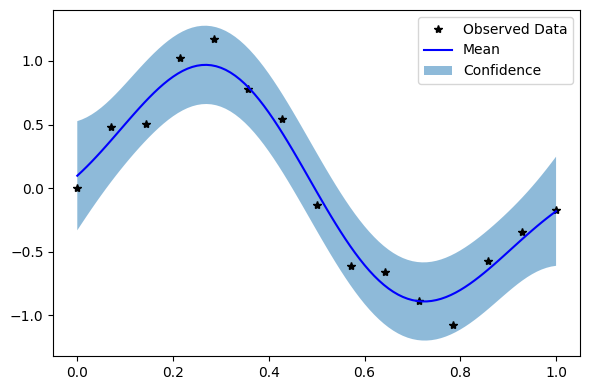

In [9]:
from matplotlib import pyplot as plt

%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), "k*")
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), "b")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(
        test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5
    )
ax.legend(["Observed Data", "Mean", "Confidence"])
plt.tight_layout()

### Interfacing with Ax

It is simple to package up a custom optimizer loop like the one above and use it within Ax. As described in Ax's [Modular BoTorch tutorial](https://ax.dev/docs/tutorials/modular_botorch/) tutorial, this requires defining a custom `model_constructor` callable that can then be passed to the `get_botorch` factory function.

In [10]:
def _get_and_fit_model(Xs, Ys, **kwargs):

    train_X, train_Y = Xs[0], Ys[0]
    model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
    model.train()

    optimizer = SGD([{"params": model.parameters()}], lr=kwargs.get("lr"))
    for epoch in range(kwargs.get("epochs")):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()

    return model